# Model for Predicting Fraudulent Transactions

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('Fraud.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.shape

(6362620, 11)

# 1.Data Cleaning

In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


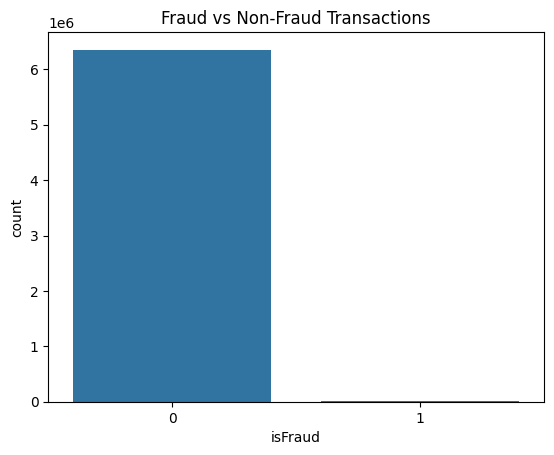

In [11]:
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

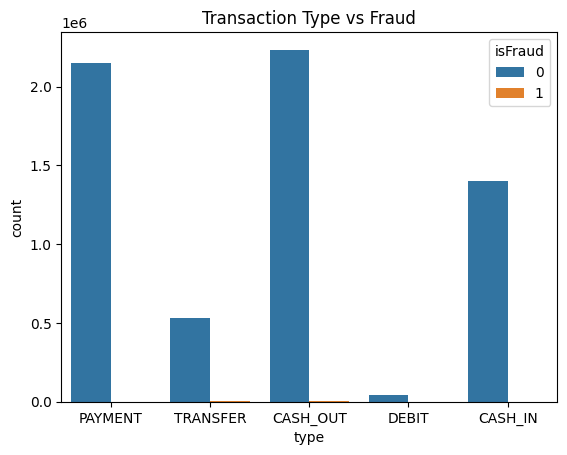

In [12]:
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Transaction Type vs Fraud')
plt.show()

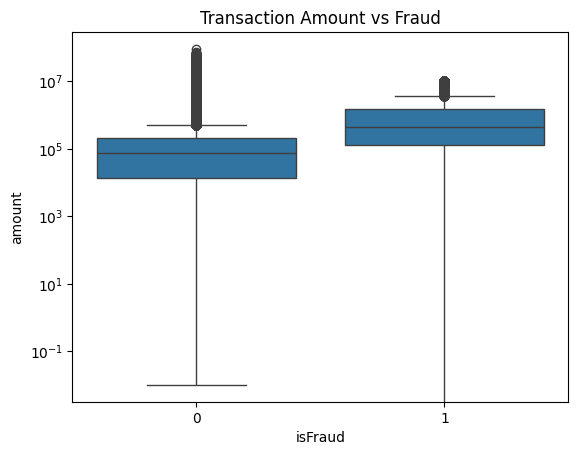

In [13]:
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount vs Fraud')
plt.yscale('log')  # Log scale to handle extreme values
plt.show()

Feature Engineering

Create balance change features

In [14]:
df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

Ratio of transaction amount to original balance

In [15]:
df['amount_to_oldbalance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # Adding 1 to avoid division by zero

Flag high-risk transaction types

In [16]:
df['isHighRiskType'] = df['type'].apply(lambda x: 1 if x in ['TRANSFER', 'CASH_OUT'] else 0)

Transaction frequency (example: counting transactions per customer per time step)

In [17]:
transaction_freq = df.groupby('nameOrig')['step'].count()
df['transaction_freq'] = df['nameOrig'].map(transaction_freq)

Drop unnecessary columns

In [18]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

 One-hot encode transaction type

In [19]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# fraud detection model

- in this we will use the RandomForestClassifier model as it is robust and well suited for classification task like fraud detection

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [22]:
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
model = RandomForestClassifier()

In [30]:
model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [31]:
y_pred = model.predict(X_test_scaled)

In [33]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

# 3. Variable Selection

In [36]:
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importances)


balance_change_orig           0.236401
balance_change_dest           0.155101
newbalanceDest                0.142456
oldbalanceOrg                 0.098420
amount                        0.089363
step                          0.071302
amount_to_oldbalance_ratio    0.052669
oldbalanceDest                0.042489
type_CASH_OUT                 0.038558
type_TRANSFER                 0.035179
newbalanceOrig                0.027479
isHighRiskType                0.008934
type_PAYMENT                  0.001505
transaction_freq              0.000125
type_DEBIT                    0.000019
dtype: float64


# 4. Model Performance

In [37]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9997233843919643


In [35]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1906313      38]
 [    490    1945]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.80      0.88      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.90      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



In [40]:
from sklearn.metrics import  roc_auc_score

# ROC-AUC score
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc}')


ROC-AUC Score: 0.9976745503827545


# 5. Key Factors Predicting Fraudulent Customers

The key factors influencing fraudulent behavior are likely:

- Transaction type (CASH_OUT, TRANSFER): Fraudsters usually attempt to empty accounts.
- Amount: Larger transactions, particularly in CASH_OUT or TRANSFER, might indicate fraud.
- Old and new balances of origin and destination accounts: Sudden and significant reductions or increases in account balances are suspicious.

# 6.Do These Factors Make Sense?

Yes, these factors make sense because:

- Fraudulent transactions often involve large sums of money being moved out of accounts (CASH_OUT/TRANSFER).
- The balance changes in the origin and destination accounts can reveal attempts to drain funds.
- Type of transaction (CASH_OUT and TRANSFER) aligns with common fraud tactics, as fraudsters aim to cash out quickly after a transfer.

# 7. Prevention Measures for Infrastructure:

To prevent fraud, the company should:

- Implement real-time monitoring: Track all high-risk transactions like large amounts or multiple rapid transactions.
- Multi-factor authentication (MFA): Make it harder for fraudsters to access accounts.
- Machine learning models for fraud detection: Continuously update and retrain models to catch new fraud patterns.
- Limit high-risk transactions: Automatically flag or prevent transfers over a certain amount until verified.

# 8. Evaluating the Effectiveness of Prevention Measures:

- Monitoring fraud rates: Check if the number of fraudulent transactions decreases over time.
- Analyzing false positives/negatives: Ensure that legitimate transactions aren’t being wrongly flagged.
- Customer feedback: Use customer reports of fraud to assess the accuracy of detection methods.
- Continuous performance monitoring of your fraud detection model: Check if the model’s precision and recall improve after implementing new measures.